In [ ]:
import pandas as pd  
import statsmodels.api as sm  #

import certifi  
import json  
import pandas as pd

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

# This function retrieves buy/sell/hold recommendations from financial analysts
# using the Financial Modeling Prep API
def get_analyst_recs(symbol):
    url = ("https://financialmodelingprep.com/api/v3/analyst-stock-recommendations/"+symbol+"?apikey="+api_key)
    
    response = urlopen(url, cafile=certifi.where())
    
    # Read and decode the JSON response from bytes to UTF-8 string
    data = response.read().decode("utf-8")
    df = pd.DataFrame(json.loads(data))
    
    # Gives us total positive analyst sentiment
    df['buy'] = df['analystRatingsbuy'] + df['analystRatingsStrongBuy']
    # Gives us total negative analyst sentiment
    df['sell'] = df['analystRatingsSell'] + df['analystRatingsStrongSell']
    # Positive spread = more bullish, negative spread = more bearish
    df['spread'] = df['buy'] - df['sell']
    
    df['date'] = pd.to_datetime(df['date'])
    
    return df

# This function retrieves multiple pages of sentiment data from StockTwits to get more historical coverage
def get_historic_sentiment(symbol, pages=1):
    df = pd.DataFrame()
    
    # Loop through specified number of pages to collect historical data
    # More pages = more historical sentiment data points
    for i in range(pages):
        url = ("https://financialmodelingprep.com/api/v4/historical/social-sentiment?symbol="+symbol+"&page="+str(i)+"&apikey="+api_key)
        
        # Make HTTP request with SSL certificate verification
        response = urlopen(url, cafile=certifi.where())
        
        # Decode the JSON response
        data = response.read().decode("utf-8")
        
        if len(df) == 0:
            # First page: create new DataFrame from JSON data
            df = pd.DataFrame(json.loads(data))
        else:
            # Subsequent pages: concatenate new data to existing DataFrame
            df = pd.concat([df, pd.DataFrame(json.loads(data))])
    
    df['timestamp'] = pd.to_datetime(df['date'])
    
    # Groups sentiment data by calendar day
    df['date'] = df['timestamp'].dt.date
    
    return df

In [30]:
large_cap_tickers = [
            # Technology
            "AAPL",  # Apple Inc.
            "MSFT",  # Microsoft Corporation
            "AMZN",  # Amazon.com, Inc.
            "GOOGL", # Alphabet Inc.
            "META",    # Meta Platforms, Inc.
            "TSLA",  # Tesla, Inc.
            # Healthcare
            "JNJ",   # Johnson & Johnson
            "PFE",   # Pfizer Inc.
            # Consumer Goods
            "PG",    # Procter & Gamble Co.
            "KO",    # Coca-Cola Company
            "PEP",   # PepsiCo, Inc.
            "NKE",   # NIKE, Inc.
            # Energy
            "XOM",   # Exxon Mobil Corporation
            "CVX",   # Chevron Corporation
            # Financial Services
            "JPM",   # JPMorgan Chase & Co.
            "C",     # Citigroup Inc.
        ]

In [ ]:
dfs = []

for ticker in large_cap_tickers:
    # Each API call returns a DataFrame with analyst recommendations for one stock
    # and we can appen each ticker's analyst recommendation DataFrame to our list
    dfs.append(get_analyst_recs(ticker))
    
# Gives us analyst recommendations for all our large cap stocks in one table
analyst_recs = pd.concat(dfs)

In [ ]:
import pickle

sent_datas = []
for ticker in large_cap_tickers:
    print("*** Fetching", ticker, "***")
    # Fetches 100 pages of historical sentiment data for each ticker
    sent_datas.append(get_historic_sentiment(ticker, 100))

# We can save the collected sentiment data to disk using pickle serialization
# This preserves all the DataFrames in their original format for later analysis
# which prevents the need to re-fetch data from API (saves time and unnecessary API calls)
with open("large_cap_sents.pkl", "wb") as f:
    pickle.dump(sent_datas, f)

In [ ]:
# Load the previously saved sentiment data from the pickle file and 
# retrieve all the historical sentiment DataFrames we collected earlier
with open("../Sentiment I/large_cap_sents.pkl", "rb") as f:
    # This restores sent_datas as a list containing sentiment DataFrames for each ticker
    sent_datas = pickle.load(f)

In [ ]:
processed_dfs = []

for df in sent_datas:
    # Group sentiment data by date and symbol, then calculate mean values
    group_mean = df.groupby(['date', 'symbol']).mean()
    
    # Reset index so that 'date' and 'symbol' are columns again, not index
    group_mean = group_mean.reset_index()
    
    processed_dfs.append(group_mean)

# Concatenate all processed DataFrames into one master dataset where
# each row represents one stock's sentiment metrics for one specific date
concatenated_df = pd.concat(processed_dfs)
concatenated_df['date'] = pd.to_datetime(concatenated_df['date'])
concatenated_df['symbol'].unique()

array(['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'JNJ', 'PFE',
       'PG', 'KO', 'PEP', 'NKE', 'XOM', 'CVX', 'JPM', 'C'], dtype=object)

In [34]:
concatenated_df.head()

,date,symbol,stocktwitsPosts,twitterPosts,stocktwitsComments,twitterComments,stocktwitsLikes,twitterLikes,stocktwitsImpressions,twitterImpressions,stocktwitsSentiment,twitterSentiment,timestamp
0,2022-10-02,AAPL,20.500000,135.500,19.500000,5780.000000,40.000000,35155.000000,39470.500000,6.704670e+05,0.534200,0.533200,2022-10-02 22:30:00
1,2022-10-03,AAPL,42.208333,257.000,18.041667,1586.083333,73.708333,8460.416667,162038.916667,1.568461e+06,0.525354,0.571042,2022-10-03 11:30:00
2,2022-10-04,AAPL,38.083333,230.750,18.416667,1243.000000,61.166667,9331.083333,160818.833333,1.557096e+06,0.540583,0.577075,2022-10-04 11:30:00
3,2022-10-05,AAPL,38.083333,243.000,21.791667,3372.333333,55.833333,13806.875000,110400.833333,4.952133e+06,0.540192,0.592229,2022-10-05 11:30:00
4,2022-10-06,AAPL,33.500000,255.375,17.958333,3225.916667,48.083333,13388.666667,68414.041667,2.422680e+06,0.535342,0.577375,2022-10-06 11:30:00


In [ ]:
merged_df = pd.merge(concatenated_df, analyst_recs, on=['date', 'symbol'])

In [36]:
merged_df[['date', 'symbol', 'stocktwitsSentiment', 'spread']].head()

,date,symbol,stocktwitsSentiment,spread
0,2022-11-01,AAPL,0.532158,32
1,2022-12-01,AAPL,0.537046,32
2,2023-01-01,AAPL,0.538637,32
3,2023-02-01,AAPL,0.533133,33
4,2023-03-01,AAPL,0.552417,33


In [ ]:
import statsmodels.api as sm
import pandas as pd
 
x = merged_df['stocktwitsSentiment'].tolist()
y = merged_df['spread'].tolist()
 
# Adding the constant term
x = sm.add_constant(x)
 
# Perform the regression and fit the model
result = sm.OLS(y, x).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           6.60e-05
Time:                        17:39:06   Log-Likelihood:                -844.13
No. Observations:                 207   AIC:                             1692.
Df Residuals:                     205   BIC:                             1699.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8853      3.770      1.561      0.1

## Regression results insights

### Model Performance

- **R-squared: 0.075** - Only 7.5% of the variation in analyst recommendation spread is explained by StockTwits sentiment, which suggests a weak relationship between social media sentiment and professional analyst opinions
- Adjusted R-squared: 0.070 - Very similar to R-squared, indicating the model isn't overfitted (very good to see)

### Practical Interpretation

- Coefficient of 31.78: For every 1-unit increase in StockTwits sentiment, the analyst buy-sell spread increases by about 32 points. 
    - This suggests that when retail investors are more bullish on social media, professional analysts also tend to be more bullish (higher buy recommendations relative to sell recommendations)

### Key Takeaways

- Social sentiment and analyst recommendations do move in the same direction, but the relationship is weak
- While statistically significant, the low R-squared means sentiment alone isn't a strong predictor of analyst recommendations


Text(0.5, 0, 'StockTwits Sentiment')

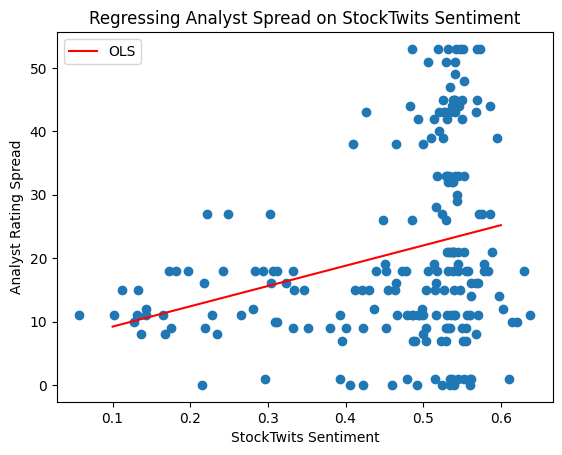

In [39]:
import numpy as np

x = np.linspace(.1, .6, 100)
y = 6 + 32*x

plt.plot(x, y, color='red', label='OLS')
plt.scatter(merged_df['stocktwitsSentiment'], merged_df['spread'])
plt.legend()
plt.title("Regressing Analyst Spread on StockTwits Sentiment")
plt.ylabel('Analyst Rating Spread')
plt.xlabel('StockTwits Sentiment')

## Graph Insights

- The red OLS line shows a clear positive trend: as StockTwits sentiment increases, analyst spread (buy minus sell recommendations) also increases
- This confirms our regression finding that retail sentiment and professional analyst opinions do move in the same direction

### Spread

- We can clearly see that data points are tightly clustered around the regression line with spreads mostly between 5-20, with a much greater variance with spreads ranging from 0 to 55+
- This suggests that when retail investors are very bullish, analyst opinions become much more dispersed (**confirming our insights from the regression results earlier**)
- On the other hand, the heavy clustering of data points in the higher sentiment range indicates that our dataset may be skewed toward more positive sentiment periods

### Improvements

This wide scatter, especially at high sentiment levels, explains the low R-squared (7.5%) and proves that **there is substantial noise in the relationship**

To combat this, we could segment the analysis by sentiment ranges or adding control variables to capture the increased variance at high sentiment levels.